# Milk Yield Prediction Project (Full Notebook with XGBoost)

This notebook is organized to match the CS 363M project rubric:

1. Data Cleaning  
2. Data Exploration (EDA)  
3. Feature Preparation and Train/Validation Split  
4. Baseline Models  
5. Expanded Supervised Modeling (including XGBoost)  
6. Unsupervised Learning and Anomaly Detection  
7. Simple Reinforcement Learning Example (Bandit)  
8. Final Model and Kaggle Submission  

All code uses only techniques covered in class up through November 14.

## 1. Imports and Data Load

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, silhouette_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, IsolationForest
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

# XGBoost (make sure xgboost is installed: `pip install xgboost` if needed)
try:
    from xgboost import XGBRegressor
    XGB_AVAILABLE = True
except ImportError:
    XGB_AVAILABLE = False
    print("Warning: xgboost not installed. Install with `pip install xgboost` to run the XGBoost cells.")

train_path = "cattle_data_train.csv"
test_path  = "cattle_data_test.csv"

train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)

train.head()

,Cattle_ID,Breed,Climate_Zone,Management_System,Age_Months,Weight_kg,Parity,Lactation_Stage,Days_in_Milk,Feed_Type,...,BVD_Vaccine,Rabies_Vaccine,Previous_Week_Avg_Yield,Body_Condition_Score,Milking_Interval_hrs,Date,Farm_ID,Feed_Quantity_lb,Mastitis,Milk_Yield_L
0,CATTLE_133713,Holstein,Tropical,Intensive,114,544.8,4,Mid,62,Concentrates,...,0,1,6.31,3.0,12,2024-01-15,FARM_0301,36.8235,1,12.192634
1,CATTLE_027003,Holstein,Arid,Mixed,136,298.9,4,Mid,213,Crop_Residues,...,0,0,17.16,4.0,12,2023-10-31,FARM_0219,NaN,0,14.717031
2,CATTLE_122459,Holstein,Tropical,Semi_Intensive,64,336.6,4,Late,16,Hay,...,1,0,4.07,3.5,12,2024-05-20,FARM_0802,16.0965,0,14.006142
3,CATTLE_213419,Jersey,Mediterranean,Intensive,58,370.5,1,Early,339,Crop_Residues,...,0,0,10.23,3.0,24,2024-07-22,FARM_0034,40.7925,0,24.324325
4,CATTLE_106260,Guernsey,Subtropical,Intensive,84,641.5,6,Early,125,Mixed_Feed,...,1,1,20.68,3.0,12,2023-01-03,FARM_0695,33.7365,1,12.023074


## 2. Data Cleaning

We clean the raw training and test data before building any models:

- Drop duplicate rows in the training data  
- Ensure the target column has no missing values  
- Fill numeric columns with the **median** from the training set  
- Fill categorical columns with the **most frequent** value from the training set  

We apply the same filling strategy to the test set using statistics computed on the training data.

In [2]:
# 2. Data Cleaning

print("Original shapes -> train:", train.shape, "test:", test.shape)

target_col = "Milk_Yield_L"

# 2.1 Drop duplicate rows in train
train = train.drop_duplicates()

# 2.2 Ensure target has no missing values (drop rows where target is NA)
if target_col in train.columns and train[target_col].isna().any():
    train = train.dropna(subset=[target_col])

# 2.3 Fill missing values using train statistics
num_cols = train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = train.select_dtypes(include=["object", "category"]).columns.tolist()

# Numeric: fill with median from train
for col in num_cols:
    median_val = train[col].median()
    train[col] = train[col].fillna(median_val)
    if col in test.columns:
        test[col] = test[col].fillna(median_val)

# Categorical: fill with most frequent value (mode) from train
for col in cat_cols:
    if train[col].isna().all():
        fill_val = "Unknown"
    else:
        fill_val = train[col].mode().iloc[0]
    train[col] = train[col].fillna(fill_val)
    if col in test.columns:
        test[col] = test[col].fillna(fill_val)

print("After cleaning -> train:", train.shape, "test:", test.shape)

print("\nRemaining missing values in train:")
print(train.isna().sum()[train.isna().sum() > 0])

print("\nRemaining missing values in test:")
print(test.isna().sum()[test.isna().sum() > 0])

Original shapes -> train: (210000, 36) test: (40000, 35)
After cleaning -> train: (210000, 36) test: (40000, 35)

Remaining missing values in train:
Series([], dtype: int64)

Remaining missing values in test:
Series([], dtype: int64)


## 3. Exploratory Data Analysis (EDA)

Here we explore the cleaned training data to understand:

- Distributions of numeric features and the target  
- Potential outliers  
- Correlations between features and milk yield  
- Basic behavior of any categorical features  

This guides later feature engineering and modeling choices.

In [3]:
# 3.1 Quick overview of the cleaned data
print(train.info())
train.describe(include="all").T.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210000 entries, 0 to 209999
Data columns (total 36 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Cattle_ID                210000 non-null  object 
 1   Breed                    210000 non-null  object 
 2   Climate_Zone             210000 non-null  object 
 3   Management_System        210000 non-null  object 
 4   Age_Months               210000 non-null  int64  
 5   Weight_kg                210000 non-null  float64
 6   Parity                   210000 non-null  int64  
 7   Lactation_Stage          210000 non-null  object 
 8   Days_in_Milk             210000 non-null  int64  
 9   Feed_Type                210000 non-null  object 
 10  Feed_Quantity_kg         210000 non-null  float64
 11  Feeding_Frequency        210000 non-null  int64  
 12  Water_Intake_L           210000 non-null  float64
 13  Walking_Distance_km      210000 non-null  float64
 14  Graz

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Cattle_ID,210000,209966,CATTLE_139671,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Breed,210000,7,Holstein,104775,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Climate_Zone,210000,6,Temperate,35224,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Management_System,210000,5,Intensive,42225,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age_Months,210000.0,NaN,NaN,NaN,83.483905,34.648982,24.0,54.0,83.0,114.0,143.0
Weight_kg,210000.0,NaN,NaN,NaN,499.93043,144.659172,250.0,374.2,500.2,625.7,750.0
Parity,210000.0,NaN,NaN,NaN,3.500395,1.707383,1.0,2.0,3.0,5.0,6.0
Lactation_Stage,210000,3,Mid,83895,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Days_in_Milk,210000.0,NaN,NaN,NaN,182.112967,105.051486,1.0,91.0,182.0,273.0,364.0
Feed_Type,210000,8,Dry_Fodder,26558,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# 3.2 Visualize missing values per column (should be mostly zero after cleaning)
missing_counts = train.isna().sum().sort_values(ascending=False)
missing_counts[missing_counts > 0]

Series([], dtype: int64)

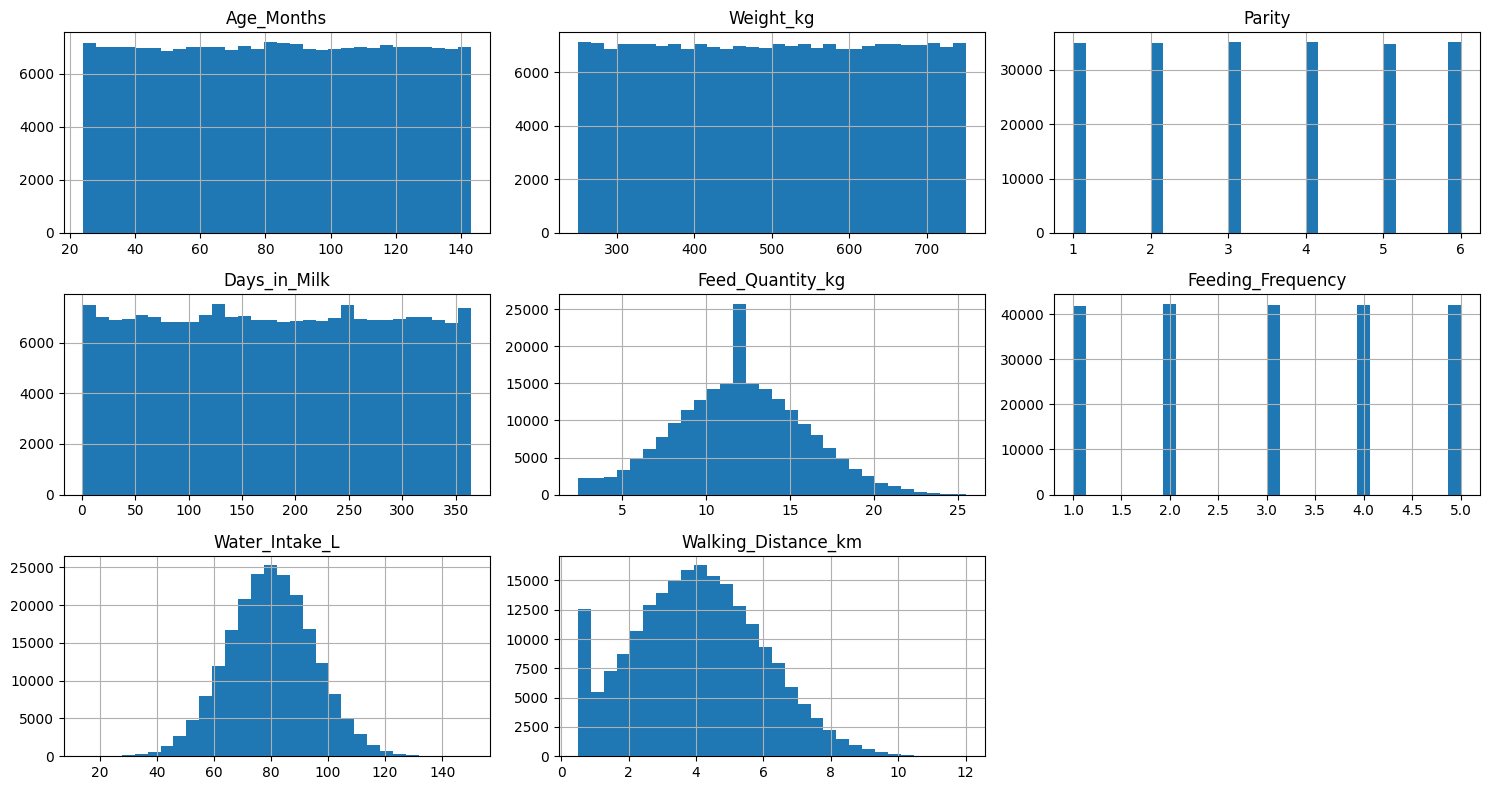

In [5]:
# 3.3 Histograms of a few numeric features and the target
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()

plt.figure(figsize=(15, 8))
cols_to_plot = numeric_cols[:8]
n = len(cols_to_plot)
nrows = int(np.ceil(n / 3))
ncols = 3

for i, col in enumerate(cols_to_plot, 1):
    plt.subplot(nrows, ncols, i)
    train[col].hist(bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()

In [6]:
# 3.4 Correlation of numeric features with the target
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
corr_matrix = train[numeric_cols].corr()

if target_col in corr_matrix.columns:
    target_corr = corr_matrix[target_col].sort_values(ascending=False)
    target_corr

## 4. Feature Preparation and Train/Validation Split

Now that the data is cleaned and we have basic EDA, we:

1. Separate the target `Milk_Yield_L` from the input features  
2. Drop ID/date-style columns that should not be used as predictors  
3. Apply a preprocessing function that:
   - fills any remaining missing numeric values with the median  
   - fills missing categorical values with `"Unknown"`  
   - one-hot encodes categorical variables with `pd.get_dummies`

In [7]:
# 4.1 Separate target and drop non-predictive columns

y = train[target_col].copy()

cols_to_drop = [c for c in ["Cattle_ID", "Farm_ID", "Date"] if c in train.columns]
if "Feed_Quantity_lb" in train.columns:
    cols_to_drop.append("Feed_Quantity_lb")

X = train.drop(columns=cols_to_drop + [target_col], errors="ignore")
X_test = test.drop(columns=[c for c in cols_to_drop if c in test.columns], errors="ignore")

test_ids = test["Cattle_ID"].copy()
X.shape, X_test.shape, y.shape

((210000, 31), (40000, 31), (210000,))

In [8]:
# 4.2 Preprocessing: median/mode fill + one-hot encode

def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    num_cols = df.select_dtypes(include=[np.number]).columns.to_list()
    cat_cols = [c for c in df.columns if c not in num_cols]

    # numeric: median fill (backup, should already be mostly filled)
    for c in num_cols:
        if df[c].isna().any():
            df[c] = df[c].fillna(df[c].median())

    # categorical: 'Unknown' fill
    for c in cat_cols:
        if df[c].isna().any():
            df[c] = df[c].fillna("Unknown")

    return pd.get_dummies(df, drop_first=False)

X_proc = preprocess(X)
X_test_proc = preprocess(X_test)

# align columns so test matches train
X_proc, X_test_proc = X_proc.align(X_test_proc, join="left", axis=1, fill_value=0)
X_proc.shape, X_test_proc.shape

((210000, 55), (40000, 55))

## 5. Baseline Models

We start with a simple 80/20 train/validation split and a few baseline models:

- Linear Regression  
- Decision Tree Regressor  
- Random Forest Regressor  

We use RMSE on the validation set as our metric.

In [9]:
# 5.1 Train/validation split and baselines

X_tr, X_val, y_tr, y_val = train_test_split(
    X_proc, y, test_size=0.2, random_state=42
)

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

baseline_models = {
    "LinearRegression": LinearRegression(),
    "DecisionTree(max_depth=10)": DecisionTreeRegressor(max_depth=10, random_state=42),
    "RandomForest(200)": RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
}

baseline_rmse_scores = {}
for name, model in baseline_models.items():
    model.fit(X_tr, y_tr)
    preds = model.predict(X_val)
    baseline_rmse_scores[name] = rmse(y_val, preds)

baseline_rmse_scores

{'LinearRegression': 4.3186005153086615,
 'DecisionTree(max_depth=10)': 4.534595018373689,
 'RandomForest(200)': 4.356773877350133}

## 6. Expanded Supervised Modeling (with XGBoost)

Now we expand to a richer set of models and tune hyperparameters using cross-validation:

- Linear Regression  
- Ridge and Lasso (regularization)  
- k-Nearest Neighbors  
- Decision Tree, Random Forest, Gradient Boosting  
- Support Vector Regression (SVR with RBF kernel)  
- Neural Net (MLPRegressor)  
- XGBoost (if available)

In [10]:
# 6.1 Cross-validation helper

X_train_features = X_proc
y_train = y

# Use a smaller 3-fold CV for speed
kf = KFold(n_splits=3, shuffle=True, random_state=0)

def cv_rmse(model):
    scores = cross_val_score(
        model,
        X_train_features,
        y_train,
        scoring="neg_mean_squared_error",
        cv=kf,
        n_jobs=-1,
    )
    return float(np.sqrt(-scores).mean())

In [11]:
# 6.2 Linear Regression (CV)
linreg = LinearRegression()
linreg_rmse = cv_rmse(linreg)
print("Linear Regression mean CV RMSE:", linreg_rmse)

Linear Regression mean CV RMSE: 4.306673715114932


In [12]:
# 6.3 Ridge and Lasso (regularization)

alphas = [0.01, 0.1, 1.0, 10.0]

ridge = Ridge(random_state=0)
ridge_grid = GridSearchCV(
    ridge,
    param_grid={"alpha": alphas},
    scoring="neg_mean_squared_error",
    cv=kf,
    n_jobs=-1,
)
ridge_grid.fit(X_train_features, y_train)
ridge_rmse = np.sqrt(-ridge_grid.best_score_)
print("Best Ridge alpha:", ridge_grid.best_params_["alpha"])
print("Ridge mean CV RMSE:", ridge_rmse)

lasso = Lasso(random_state=0, max_iter=10000)
lasso_grid = GridSearchCV(
    lasso,
    param_grid={"alpha": alphas},
    scoring="neg_mean_squared_error",
    cv=kf,
    n_jobs=-1,
)
lasso_grid.fit(X_train_features, y_train)
lasso_rmse = np.sqrt(-lasso_grid.best_score_)
print("Best Lasso alpha:", lasso_grid.best_params_["alpha"])
print("Lasso mean CV RMSE:", lasso_rmse)

Best Ridge alpha: 10.0
Ridge mean CV RMSE: 4.306670124247692
Best Lasso alpha: 0.01
Lasso mean CV RMSE: 4.3065245379087616


In [13]:
# 6.4 k-Nearest Neighbors regression

knn_params = {"n_neighbors": [3, 5, 11]}
knn = KNeighborsRegressor()
knn_grid = GridSearchCV(
    knn,
    param_grid=knn_params,
    scoring="neg_mean_squared_error",
    cv=kf,
    n_jobs=-1,
)
knn_grid.fit(X_train_features, y_train)
knn_rmse = np.sqrt(-knn_grid.best_score_)
print("Best k:", knn_grid.best_params_["n_neighbors"])
print("KNN mean CV RMSE:", knn_rmse)

Best k: 11
KNN mean CV RMSE: 4.878583452150081
